In [1]:
!pip install pmdarima

In [15]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pmdarima as pm
from pmdarima import auto_arima
import plotly.graph_objects as go

In [53]:
# Import data
df = pd.read_csv('../content/drive/My Drive/Dataset/S&P500-Jan2010-to-Dec2019.csv')
#df = pd.read_csv('../content/drive/My Drive/Dataset/AMD-Jan2010-to-Dec2019.csv')

#df = pd.read_csv('../content/drive/My Drive/Dataset/S&P500-Jan2010-to-May2020.csv')
#df = pd.read_csv('../content/drive/My Drive/Dataset/AMD-10.5YEAR.csv')

In [31]:
# Normal
# Train & test split
# To test how the model does with out sample prediction
X_train, X_test = train_test_split(df, test_size=0.1, random_state=None, shuffle=False)

# 90% train 10% test
# Train from 2010-01-04 to 2018-12-28
train = X_train[['Close']]
train.index = pd.to_datetime(X_train['Date'])

# Test from 2018-12-31 to 2019-12-30
test = X_test[['Close']]
test.index = pd.to_datetime(X_test['Date'])

In [54]:
# Other tests to test for short-term prediction and COVID-19
# 2455 for 60-days
# 2412 for 103-days
# 2515 for COVID-19 but df must be changed to the 10.5 years one

slicing = 2455

train = df[['Close']][:slicing] 
train.index = pd.to_datetime(df['Date'][:slicing])

test = df[['Close']][slicing:] 
test.index = pd.to_datetime(df['Date'][slicing:])

#start = 2515-103-103
#slicing = 2412

train = df[['Close']][:slicing] 
train.index = pd.to_datetime(df['Date'][:slicing])

test = df[['Close']][slicing:] 
test.index = pd.to_datetime(df['Date'][slicing:])

In [55]:
# Parameters of ARIMA model
p = 1
d = 1
q = 1

# To predict in-sample prediction
start = d
end = train.shape[0]

# For out-sample or test prediction 
steps = test.shape[0]

In [5]:
# To test the stationarity of the undifferenced or differenced time series
# Reference from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/# (Jain, 2016)

def test_stationarity(timeseries):
    
  # Determining rolling statistics:
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  # Plot rolling statistics:
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  # Perform Dickey-Fuller test:
  print('Results of Dickey-Fuller Test:')
  data1 = timeseries.iloc[:,0].values
  dftest = adfuller(data1, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [6]:
# To plot ACF and PACF of the differenced timeseries
def plot_acf_pacf(timeseries):
  # Plot ACF - MA
  fig, ax = plt.subplots(figsize=(12,5))
  plot_acf(timeseries, lags=20, ax=ax)
  plt.show()

  # Plot PACF - AR
  fig, ax = plt.subplots(figsize=(12,5))
  plot_pacf(timeseries, lags=20, ax=ax) 
  plt.show()




Before Differencing


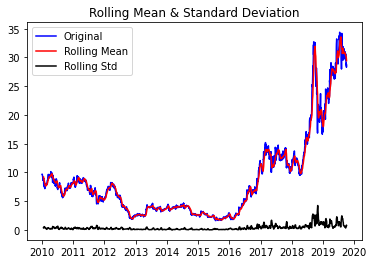

Results of Dickey-Fuller Test:
Test Statistic                   -0.360266
p-value                           0.916525
#Lags Used                       18.000000
Number of Observations Used    2436.000000
Critical Value (1%)              -3.433037
Critical Value (5%)              -2.862727
Critical Value (10%)             -2.567402
dtype: float64



1st Degree Differencing


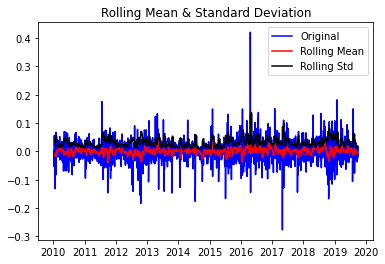

Results of Dickey-Fuller Test:
Test Statistic                  -28.948296
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    2451.000000
Critical Value (1%)              -3.433021
Critical Value (5%)              -2.862720
Critical Value (10%)             -2.567398
dtype: float64



2nd Degree Differencing


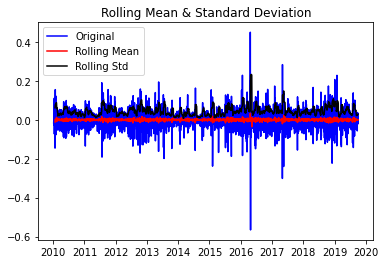

Results of Dickey-Fuller Test:
Test Statistic                -1.648666e+01
p-value                        2.211718e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.425000e+03
Critical Value (1%)           -3.433049e+00
Critical Value (5%)           -2.862733e+00
Critical Value (10%)          -2.567405e+00
dtype: float64



3rd Degree Differencing


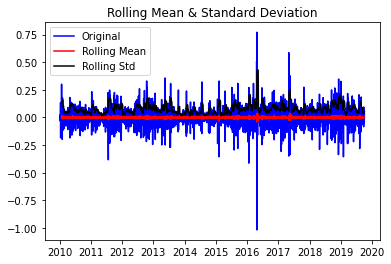

Results of Dickey-Fuller Test:
Test Statistic                  -21.332822
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    2424.000000
Critical Value (1%)              -3.433051
Critical Value (5%)              -2.862733
Critical Value (10%)             -2.567405
dtype: float64


In [7]:
# Before differencing
print('\n\n\nBefore Differencing')
test_stationarity(train)

# Differencing - 1st Method
# 1st Degree Differencing
data_log_diff_1 = np.log(train).diff()
data_log_diff_1.dropna(inplace=True)

print('\n\n\n1st Degree Differencing')
test_stationarity(data_log_diff_1)

# 2nd Degree Differencing
data_log_diff_2 = data_log_diff_1.diff()
data_log_diff_2.dropna(inplace=True)

print('\n\n\n2nd Degree Differencing')
test_stationarity(data_log_diff_2)

# 3rd Degree Differencing
data_log_diff_3 = data_log_diff_2.diff()
data_log_diff_3.dropna(inplace=True)

print('\n\n\n3rd Degree Differencing')
test_stationarity(data_log_diff_3)

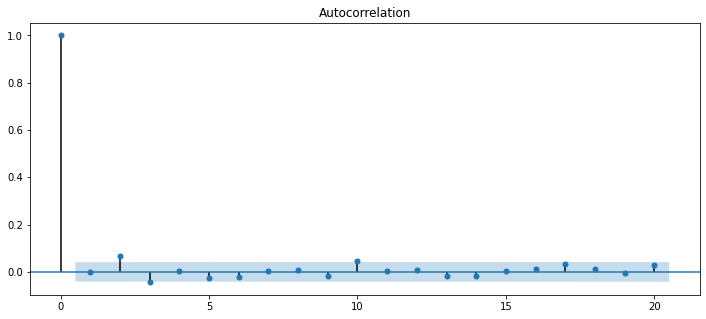

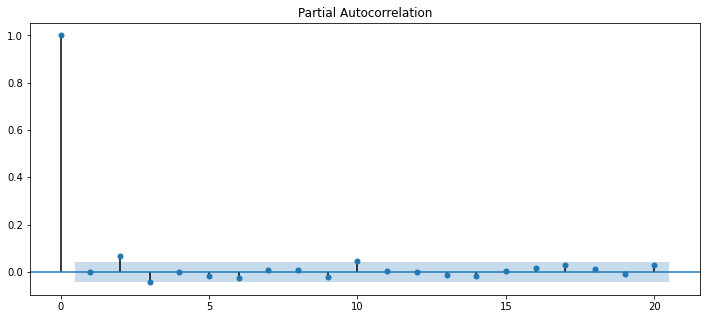

In [8]:
plot_acf_pacf(data_log_diff_1)

In [9]:
# auto-ARIMA
def autoarima(train):
  stepwise_fit = pm.auto_arima(train) 
  print(stepwise_fit.summary())

# Determine the ARIMA order using Auto ARIMA function
autoarima(train)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2263
Model:               SARIMAX(0, 1, 4)   Log Likelihood                -779.651
Date:                Wed, 19 Aug 2020   AIC                           1569.302
Time:                        17:18:58   BIC                           1597.922
Sample:                             0   HQIC                          1579.745
                               - 2263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0152      0.008      1.882      0.060      -0.001       0.031
ma.L2          0.1272      0.009     13.904      0.000       0.109       0.145
ma.L3         -0.1132      0.010    -11.863      0.0

In [8]:
#@title Fit ARIMA model and make prediction based on the timesteps in the testing dataset
def build_ARIMA(train,p,d,q,start,end,steps):
  model = ARIMA(train, order=(p, d, q))
  train_fit = model.fit(disp=False)

  # Print Model Summary
  model_summary = print(train_fit.summary())

  # using 'typ = levels' to get the actual value rather than the differenced values for performance metrics
  train_prediction = train_fit.predict(start=start, end=end, exog=None, typ = 'levels') 

  train_predict = pd.DataFrame({'Close':train_prediction.values})
  train_predict.index = pd.to_datetime(train.index)

  test_forecast = train_fit.forecast(steps=steps)[0]
  test_predict = pd.DataFrame(data=test_forecast, columns=['Close'])
  test_predict.index = pd.to_datetime(test.index)

  return [train_fit, model_summary, train_predict, test_predict]

In [9]:
#@title Performance Metrics: Calculate Trend Accuracy
# This function is used to calculate whether the model has correctly predicted the correct trend
def calculate_correct_trend(train, train_predict, test, test_predict):
  n = 1
  upward_downward_list = [] # 1 means upward, 0 means downwards
  for i in train.values[1:]:
    ytd_index = n - 1
    ytd = train.values[ytd_index]
    today = train.values[n]
    if (today - ytd) >= 0:
      upward_downward_list.append(1)
    else:
      upward_downward_list.append(0)
    n = n + 1

  m = 1
  predict_upward_downward_list = [] # 1 means upward, 0 means downwards
  for j in train_predict.values[1:]:
    ytd_index = m - 1
    ytd = train_predict.values[ytd_index]
    today = train_predict.values[m]
    if (today - ytd) >= 0:
      predict_upward_downward_list.append(1)
    else:
      predict_upward_downward_list.append(0)
    m = m + 1

  train_correct = 0
  train_all = 0
  for k in range(len(upward_downward_list)):
    # if the correct trend is predicted, the difference is 0 
    if (upward_downward_list[k] - predict_upward_downward_list[k]) == 0: 
      train_correct = train_correct + 1
      train_all = train_all + 1
    else:
      train_all = train_all + 1

  # training accuracy is based on the number of correct trend predicted over the number of samples
  train_accuracy = train_correct/train_all *100

  test_n = 1
  test_upward_downward_list = [] # 1 means upward, 0 means downwards
  for i in test.values[1:]:
    ytd_index = test_n - 1
    ytd = test.values[ytd_index]
    today = test.values[test_n]
    if (today - ytd) >= 0:
      test_upward_downward_list.append(1)
    else:
      test_upward_downward_list.append(0)
    test_n = test_n + 1

  test_m = 1
  test_predict_upward_downward_list = [] # 1 means upward, 0 means downwards
  for j in test_predict.values[1:]:
    ytd_index = test_m - 1
    ytd = test_predict.values[ytd_index]
    today = test_predict.values[test_m]
    if (today - ytd) >= 0:
      test_predict_upward_downward_list.append(1)
    else:
      test_predict_upward_downward_list.append(0)
    test_m = test_m + 1

  test_correct = 0
  test_all = 0
  for i in range(len(test_predict_upward_downward_list)):
    if (test_upward_downward_list[i] - test_predict_upward_downward_list[i]) == 0:
      test_correct = test_correct + 1
      test_all = test_all + 1
    else:
      test_all = test_all + 1

  test_accuracy = test_correct/test_all * 100

  overall_accuracy = (train_correct + test_correct)/(train_all + test_all) * 100

  plt.figure(figsize=(20,5)).gca().yaxis.set_major_locator(MaxNLocator(integer=True))
  plt.plot(test_upward_downward_list, color = 'blue', label='actual')
  plt.plot(test_predict_upward_downward_list, color='red', label='predicted')
  plt.xlabel('index')
  plt.ylabel('stock price')
  plt.title('Testing set in predicting the correct trend (1 = upward trend and 0 = downward trend)')
  plt.legend()
  plt.show()

  train_accuracy = round(train_accuracy, 2)
  test_accuracy = round(test_accuracy, 2)
  overall_accuracy = round(overall_accuracy, 2)

  return train_accuracy, test_accuracy, overall_accuracy

In [10]:
#@title Performance Metrics: Calculate Confidence Interval Accuracy
# This function is to see whether most of the values fall within the 95% confidence range
def calculate_confidence(train, train_predict, test, test_predict):
  train_lower_limit = []
  train_upper_limit = []
  for i in train.values:
    lower = i * 0.975
    upper = i * 1.025
    train_lower_limit.append(lower)
    train_upper_limit.append(upper)

  train_correct = 0
  train_all = 0
  n = 0
  for j in train_predict.values:
    # if the predicted value is within the range then it has correctly predicted within the range
    if j >= train_lower_limit[n] and j <= train_upper_limit[n]:
      train_correct = train_correct + 1
      train_all = train_all + 1
    else:
      train_all = train_all + 1
    n = n +1
  
  # Training accuracy is based on the number of times it correctly predicted within the 95% confidence range
  train_ci_accuracy = train_correct/train_all * 100

  test_lower_limit = []
  test_upper_limit = []
  for k in test.values:
    lower = k * 0.975
    upper = k * 1.025
    test_lower_limit.append(lower)
    test_upper_limit.append(upper)

  test_correct = 0
  test_all = 0
  m = 0
  for l in test_predict.values:
    if l >= test_lower_limit[m] and l <= test_upper_limit[m]:
      test_correct = test_correct + 1
      test_all = test_all + 1
    else:
      test_all = test_all + 1
    m = m +1

  test_ci_accuracy = test_correct/test_all * 100

  overall_ci_accuracy = (train_correct+test_correct)/(train_all+test_all) * 100

  plt.figure(figsize=(20,5))
  plt.plot(test_lower_limit, color = 'blue', label='lower')
  plt.plot(test_predict.values, color='red', label='predicted')
  plt.plot(test_upper_limit, color='green', label='upper')
  plt.title('A comparison of the predicted stock price over the 95% Confidence Interval range')
  plt.xlabel('Index')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

  train_ci_accuracy = round(train_ci_accuracy, 2)
  test_ci_accuracy = round(test_ci_accuracy, 2)
  overall_ci_accuracy = round(overall_ci_accuracy, 2)

  return train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy

In [11]:
#@title Actual vs Predicted Plot
def actual_predicted_plot(train, train_predict, test, test_predict):
  # TRAIN
  # Actual VS Predicted
  plt.figure(figsize=(20,5))
  plt.plot(train, color = 'blue', label='actual')
  plt.plot(train_predict, color='red', label='predicted')
  plt.xlabel('Year')
  plt.ylabel('Stock Price')
  plt.title('Actual VS Predicted on Training Set')
  plt.show()

  # TEST
  # Actual VS Predicted
  plt.figure(figsize=(20,5))
  plt.plot(test, color = 'blue', label='actual')
  plt.plot(test_predict, color='red', label='predicted')
  plt.xlabel('Year')
  plt.ylabel('Stock Price')
  plt.title('Actual VS Predicted on Testing Set')
  plt.legend()
  plt.show()

In [12]:
#@title Performance Metrics: MAE, MSE, RMSE, R2, MAPE and Generate Table
def calculateMAE(train, train_predict, test, test_predict):
  whole_set = np.concatenate((train.values[:], test.values))
  whole_prediction = np.concatenate((train_predict.values, test_predict.values))

  train_mae = mean_absolute_error(train.values[:], train_predict)
  test_mae = mean_absolute_error(test, test_predict)
  whole_mae = mean_absolute_error(whole_set, whole_prediction)

  train_mae = str(round(train_mae, 2))
  test_mae = str(round(test_mae, 2))
  whole_mae = str(round(whole_mae, 2))

  return [train_mae,test_mae, whole_mae]

def calculateMSE(train, train_predict, test, test_predict):
  whole_set = np.concatenate((train.values[:], test.values))
  whole_prediction = np.concatenate((train_predict.values, test_predict.values))

  train_mse = mean_squared_error(train.values[:], train_predict)
  test_mse = mean_squared_error(test, test_predict)
  whole_mse = mean_squared_error(whole_set, whole_prediction)

  train_mse = str(round(train_mse, 2))
  test_mse = str(round(test_mse, 2))
  whole_mse = str(round(whole_mse, 2))

  return [train_mse,test_mse, whole_mse]

def calculateRMSE(train, train_predict, test, test_predict):
  whole_set = np.concatenate((train.values[:], test.values))
  whole_prediction = np.concatenate((train_predict.values, test_predict.values))

  train_rmse = mean_squared_error(train.values[:], train_predict,squared=False)
  test_rmse = mean_squared_error(test, test_predict,squared=False)
  whole_rmse = mean_squared_error(whole_set, whole_prediction,squared=False)

  train_rmse = str(round(train_rmse, 2))
  test_rmse = str(round(test_rmse, 2))
  whole_rmse = str(round(whole_rmse, 2))

  return [train_rmse,test_rmse,whole_rmse]

def calculateR2(train, train_predict, test, test_predict):
  whole_set = np.concatenate((train.values[:], test.values))
  whole_prediction = np.concatenate((train_predict.values, test_predict.values))

  train_r2 = r2_score(train.values[:], train_predict)
  test_r2 = r2_score(test, test_predict)
  whole_r2 = r2_score(whole_set, whole_prediction)

  train_r2 = str(round(train_r2, 2))
  test_r2 = str(round(test_r2, 2))
  whole_r2 = str(round(whole_r2, 2))

  return [train_r2,test_r2,whole_r2]

def calculateMAPE(train, train_predict, test, test_predict): 
  whole_set = np.concatenate((train.values[:], test.values))
  whole_prediction = np.concatenate((train_predict.values, test_predict.values))

  y_train_true, y_train_pred = train.values[:], train_predict.values
  train_mape = np.mean(np.abs((y_train_true - y_train_pred) / y_train_true)) * 100

  y_test_true, y_test_pred = test.values, test_predict.values
  test_mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

  y_whole_true, y_whole_pred = whole_set, whole_prediction
  whole_mape = np.mean(np.abs((y_whole_true - y_whole_pred) / y_whole_true)) * 100

  train_mape = str(round(train_mape, 2))
  test_mape = str(round(test_mape, 2))
  whole_mape = str(round(whole_mape, 2))

  return [train_mape,test_mape, whole_mape]

def generate_metrics(train, train_predict, test, test_predict):
  #row
  first_row = ['','MAE', 'MSE', 'RMSE', 'R2','MAPE']

  #header
  first_column = ['Train Set', 'Test Set', 'Whole Set']
  mae = calculateMAE(train, train_predict, test, test_predict)
  mse = calculateMSE(train, train_predict, test, test_predict)
  rmse = calculateRMSE(train, train_predict, test, test_predict)
  r2 = calculateR2(train, train_predict, test, test_predict)
  mape = calculateMAPE(train, train_predict, test, test_predict)

  # https://plotly.com/python/table/
  fig = go.Figure(data=[go.Table(header=dict(values=first_row),
                 cells=dict(values=[first_column,mae,mse,rmse,r2,mape]))
                     ])
  fig.update_layout(width=800, height=500)
  fig.show()

The Tests

In [ ]:
# Uncomment this when build model with d = 2 
# end = end + 1

# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,p,d,q,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,2,d,2,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,5,d,5,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,7,d,7,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,14,d,14,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,18,d,11,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,10,d,10,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,0,d,4,start,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# Uncomment this when build model with d = 2 
end = end + 1

# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,1,2,1,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,2,2,2,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,4,2,4,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,12,2,3,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,13,2,1,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,18,2,1,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# To build the ARIMA model with the specified order and show its performance metrics
train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,20,2,5,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))

In [ ]:
# Other test set
# S&P500 - 7,1,7
# AMD - 1,2,1

# Uncomment this when build model with d = 2 
end = train.shape[0] + 1

train_fit, model_summary, train_predict, test_predict = build_ARIMA(train,7,2,7,2,end,steps)
train_ci_accuracy, test_ci_accuracy, overall_ci_accuracy = calculate_confidence(train, train_predict, test, test_predict)
train_accuracy, test_accuracy, overall_accuracy = calculate_correct_trend(train, train_predict, test, test_predict)
actual_predicted_plot(train, train_predict, test, test_predict)
generate_metrics(train, train_predict, test, test_predict)
print('Test CI accuracy :' + str(test_ci_accuracy))
print('Test trend accuracy :' + str(test_accuracy))